# Import libraries

In [26]:
import os
import numpy as np 
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

 
import seaborn as sns
from tensorflow import keras
from keras import backend as K
from scipy.io.wavfile import read
from keras.layers import Activation
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D


import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrixfrom sklearn.metrics import plot_confusion_matrix

## EDA

In [3]:
patient_data=pd.read_csv("patient_diagnosis.csv",names=['patient_id','disease'])
patient_data

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [4]:
df=pd.read_csv('audio_and_txt_files/101_1b1_Al_sc_Meditron.txt',sep='\t')
df

,0.036,0.579,0,0.1
0,0.579,2.450,0,0
1,2.450,3.893,0,0
2,3.893,5.793,0,0
3,5.793,7.521,0,0
4,7.521,9.279,0,0
5,9.279,11.150,0,0
6,11.150,13.036,0,0
7,13.036,14.721,0,0
8,14.721,16.707,0,0
9,16.707,18.507,0,0


In [5]:
path='audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [6]:
def getFilenameInfo(file):
    return file.split('_')

In [7]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

## Tranforming Data

In [8]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data = getFilenameInfo(file)
    data['patient_id']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df

,start,end,crackles,weezels,patient_id,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron
...,...,...,...,...,...,...,...
6,11.721,13.693,1,0,226,sc,226_1b1_Pl_sc_LittC2SE
7,13.693,15.536,0,0,226,sc,226_1b1_Pl_sc_LittC2SE
8,15.536,17.493,0,0,226,sc,226_1b1_Pl_sc_LittC2SE
9,17.493,19.436,1,0,226,sc,226_1b1_Pl_sc_LittC2SE


In [9]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  126 non-null    int64 
 1   disease     126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start       6898 non-null   float64
 1   end         6898 non-null   float64
 2   crackles    6898 non-null   int64  
 3   weezels     6898 non-null   int64  
 4   patient_id  6898 non-null   object 
 5   mode        6898 non-null   object 
 6   filename    6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


### Getting pid of both to same type and merge both dataframes on pid 

In [11]:
patient_data.patient_id=patient_data.patient_id.astype('int32')
files_df.patient_id=files_df.patient_id.astype('int32')

In [12]:
data=pd.merge(files_df,patient_data,on='patient_id')
data

,start,end,crackles,weezels,patient_id,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6894,13.693,15.536,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6895,15.536,17.493,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6896,17.493,19.436,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia


In [13]:
# os.makedirs('csv_data')
# data.to_csv('csv_data/data.csv',index=False)

## Visualizing audio

In [15]:
%matplotlib inline
filename='104_1b1_Pr_sc_Litt3200.wav'

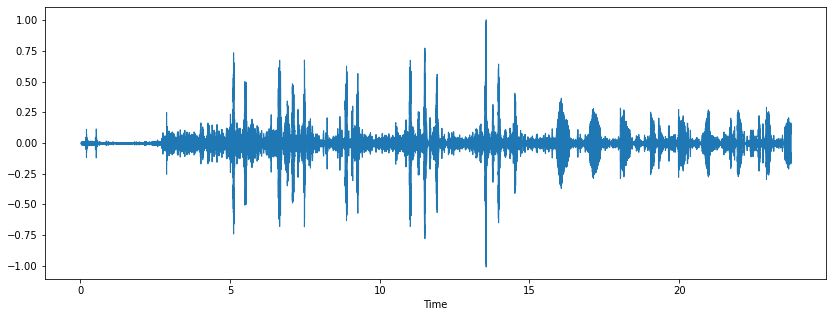

In [16]:
plt.figure(figsize=(14,5))
data1,sample_rate=librosa.load(filename)
librosa.display.waveshow(data1,sr=sample_rate)
ipd.Audio(filename)

In [17]:
sample_rate

22050

In [18]:
data

,start,end,crackles,weezels,patient_id,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6894,13.693,15.536,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6895,15.536,17.493,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6896,17.493,19.436,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia


### Testing with SciPy

In [19]:
wave_sample_rate, wave_audio=wav.read(filename)

In [20]:
wave_sample_rate

4000

In [21]:
wave_audio

array([    0,     1,     0, ..., -2932, -3425, -3750], dtype=int16)

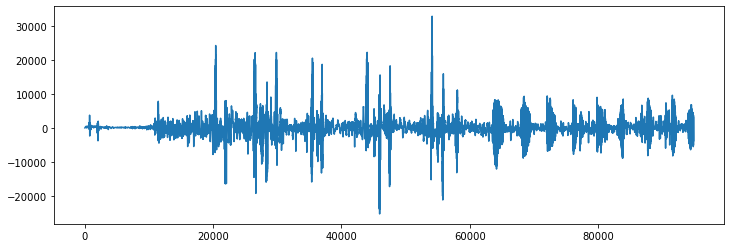

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

## 2. Processing Audio files
#### Now we only want that parts from whole audio file which contains Respiratory Cycles. 
#### This is denoted by the start and end times mentioned in the txt files.

In [23]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

#### We multiplied start with sampling rate cause start is time and raw_data is array sampled acc. to sampling rate
#### Now we also want our input images to our cnn to be of same size for that audio files must be of same length i.e (start - end) must be same.

#### So, We need to find the best length we can have.

# Outlier Detection:

In [24]:
#Getting the max length per file that we currently have in our dataframe

data['len_per_slice'] = data['end'].sub(data['start'], axis = 0) 
max_len_per_slice = max(data['len_per_slice'])
max_len_per_slice

16.163

#### It isn't possible for someone to have 1 breathe as long as 16 seconds.

#### So we try and understand our data and check the outliers and the relative maximum of the dataset.

<AxesSubplot:ylabel='patient_id'>

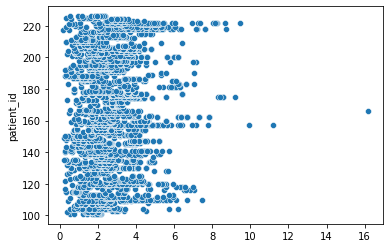

In [27]:
sns.scatterplot(x=(data.end-data.start), y=data.patient_id)

<AxesSubplot:>

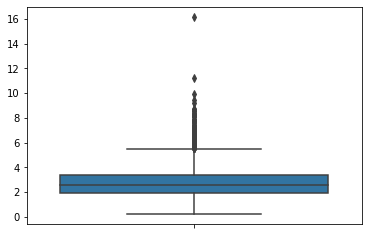

In [28]:
sns.boxplot(y=(data.end-data.start))

#### From these plots we can conclude that best length is ~6

#### Also if difference is <6 we must Zero Pad it to get it to required length(Zero Padding means silent).

In [29]:
# os.makedirs('processed_audio_files')

In [30]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                             0.036
end                               0.579
crackles                              0
weezels                               0
patient_id                          101
mode                                 sc
filename         101_1b1_Al_sc_Meditron
disease                            URTI
len_per_slice                     0.543
Name: 0, dtype: object


#### Also a single sample of audio file can have Many Respiratory Cycles so we might have to create multiple files for a single audio file

#### We will be using Librosa module for loading audio files and Soundfile module for writing to output path.


In [6]:
# i,c=0,0
# for index,row in data.iterrows():
#     maxLen=6
#     start=row['start']
#     end=row['end']
#     filename=row['filename']
    
#     #If len > maxLen , change it to maxLen
#     if end-start>maxLen:
#         end=start+maxLen
    
#     audio_file_loc = path + filename + '.wav'
    
#     if index > 0:
#         #check if more cycles exits for same patient if so then add i to change filename
#         if data.iloc[index-1]['filename']==filename:
#             i+=1
#         else:
#             i=0
#     filename= filename + '_' + str(i) + '.wav'
    
#     save_path='processed_audio_files/' + filename
#     c+=1
    
#     audioArr,sampleRate=lb.load(audio_file_loc)
#     pureSample=getPureSample(audioArr,start,end,sampleRate)
    
#     #pad audio if pureSample len < max_len
#     reqLen=6*sampleRate
#     padded_data = lb.util.pad_center(pureSample, reqLen)
    
#     sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
# print('Total Files Processed: ',c)

### Classification of classes into COPD and Non COPD

In [32]:
diagnosis=pd.read_csv('patient_diagnosis.csv',names=['patient_id','disease'])
diagnosis.head()

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [33]:
# Change all fields except 'COPD' as 'non-COPD'
diagnosis['disease'] = diagnosis['disease'].apply(lambda x: 'non-COPD' if x != 'COPD' else 'COPD')
 
# Print the dataset
diagnosis

,patient_id,disease
0,101,non-COPD
1,102,non-COPD
2,103,non-COPD
3,104,COPD
4,105,non-COPD
...,...,...
121,222,COPD
122,223,COPD
123,224,non-COPD
124,225,non-COPD


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, 'non-COPD'), Text(1, 0, 'COPD')])

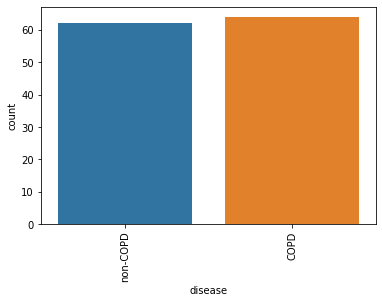

In [34]:
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

#### We will try to extract Id of each processed audio file and then merge them with their respective class label so we can split files in to train and validation folder in stratified manner

In [35]:
def extractId(filename):
    return filename.split('_')[0]

In [36]:
path='processed_audio_files'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['patient_id','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['patient_id']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,patient_id,filename
0,101,101_1b1_Al_sc_Meditron_0.wav
1,101,101_1b1_Al_sc_Meditron_1.wav
2,101,101_1b1_Al_sc_Meditron_10.wav
3,101,101_1b1_Al_sc_Meditron_11.wav
4,101,101_1b1_Al_sc_Meditron_2.wav


In [37]:
files_df.patient_id=files_df.patient_id.astype('int64') # both pid's must be of same dtype for them to merge

In [38]:
data=pd.merge(files_df,diagnosis,on='patient_id')
data.head()

,patient_id,filename,disease
0,101,101_1b1_Al_sc_Meditron_0.wav,non-COPD
1,101,101_1b1_Al_sc_Meditron_1.wav,non-COPD
2,101,101_1b1_Al_sc_Meditron_10.wav,non-COPD
3,101,101_1b1_Al_sc_Meditron_11.wav,non-COPD
4,101,101_1b1_Al_sc_Meditron_2.wav,non-COPD


In [3]:
Xtrain,Xtest,ytrain,ytest=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [40]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD        0.832979
non-COPD    0.167021
Name: disease, dtype: float64

In [41]:
Xtest.disease.value_counts()/Xtest.shape[0]

COPD        0.833043
non-COPD    0.166957
Name: disease, dtype: float64

##### Percent of class labels in same in both train and test as we can see above
##### We did this because this will help our model to learn and validate classes , it will not be like we are training only on COPD disease and there is no COPD in our validation 

## Visualizing MFCCS

[Text(0.5, 1.0, 'MFCC')]

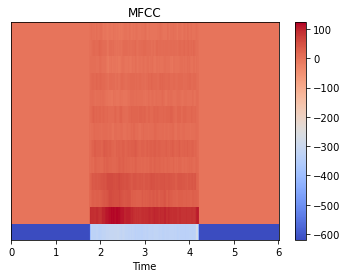

In [42]:
path='processed_audio_files/'

file=path + Xtrain.iloc[193].filename 
sound,sample_rate=lb.load(file)

#n_mfcc is the number of coefficients we want to extract
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=13)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

##### Here We are going to output train & test datasets so that we can use the filenames in another notebook where we will try other feature extraction methods inclusive of MFCC's and adopt the one or many based on performance.

In [43]:
Xtrain.to_csv('train.csv')
Xtest.to_csv('test.csv')

In [44]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [45]:
train.head()

,Unnamed: 0,patient_id,filename,disease
0,4549,178,178_1b2_Lr_mc_AKGC417L_4.wav,COPD
1,3858,170,170_1b3_Al_mc_AKGC417L_2.wav,COPD
2,120,106,106_2b1_Pr_mc_LittC2SE_6.wav,COPD
3,2072,140,140_2b2_Ll_mc_LittC2SE_2.wav,non-COPD
4,2369,147,147_2b3_Al_mc_AKGC417L_0.wav,COPD


In [46]:
ytrain=train.disease
ytest=test.disease
ytest

0       non-COPD
1           COPD
2           COPD
3           COPD
4           COPD
          ...   
1720        COPD
1721        COPD
1722        COPD
1723        COPD
1724        COPD
Name: disease, Length: 1725, dtype: object

#### As our class labels are of object data type, so we must first convert them to encoded values or intergers (categorical)

In [47]:
le=LabelEncoder()

ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

### Feature Extraction
##### We are going to use Librosa's feature extraction methods here

##### Note:- We first tried to extract features 1-by-1 and then concatenated them into a single feature

In [ ]:
# def getFeatures_mfcc(path):
#     soundArr,sample_rate=lb.load(path)
#     mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)

#     return mfcc

In [ ]:
# def getFeatures_cstft(path):
#     soundArr,sample_rate=lb.load(path)
#     cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)

#     return cstft

In [ ]:
# def getFeatures_mSpec(path):
#     soundArr,sample_rate=lb.load(path)
#     mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

#     return mSpec

In [48]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)
    feat_merge = np.concatenate((mfcc,cstft,mSpec), axis=0)
    
    return feat_merge

In [49]:
root='processed_audio_files/'
merged=[]

for idx,row in test.iterrows():
    path=root + row['filename']
    a=getFeatures(path)
    merged.append(a)
    
    
merged_test=np.array(merged)


C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [50]:
merged_test.shape

(1725, 160, 259)

In [51]:
re_merged_test= merged_test.reshape(-1,1725, 160, 259)

In [ ]:
root='processed_audio_files/'
merged=[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a=getFeatures(path)
    merged.append(a)
    
    
merged_train=np.array(merged)


In [ ]:
merged_train.shape

In [ ]:
re_merged_train= merged_train.reshape(-1,5173, 160, 259)

In [8]:
model = Sequential(name='jmd')
filter_size = 2
filter_size = 2
pool_size = 2

model.add(Conv2D(filters=16, kernel_size=filter_size, input_shape=(160,259,1), activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(1, activation='sigmoid'))


In [93]:
model.summary()

Model: "jmd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 159, 258, 16)      80        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 79, 129, 16)      0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 79, 129, 16)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 78, 128, 32)       2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 39, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 39, 64, 32)        0       

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

# Compiling the Model

In [108]:
my_callbacks = [
    
    #Stop training when a monitored metric has stopped improving.
    #patience: Number of epochs with no improvement after which training will be stopped.
    tf.keras.callbacks.EarlyStopping(patience=5),
    
    #Reduce learning rate when a metric has stopped improving.
    #monitor: quantity to be monitored.
    #factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [117]:
# Hyperparamter tuning done with nadam as well
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.001)

# Training model

In [103]:
history=model.fit(merged_train,ytrain,validation_data=(merged_test,ytest),epochs=100,verbose=0,callbacks=my_callbacks)

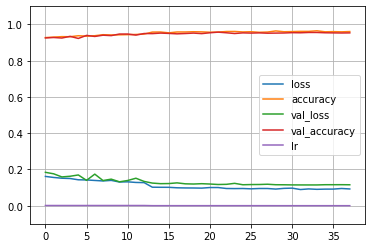

54/54 [==============================] - 7s 123ms/step - loss: 0.1154 - accuracy: 0.9536


[0.1153881847858429, 0.9536231756210327]

In [104]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

model.evaluate(merged_test,ytest) 

# Cross Validation:

In [116]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    results = model.fit(merged_train, ytrain, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=my_callbacks, 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(merged_test, ytest))
    return resultsv

In [118]:
n_folds=3
epochs=10
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(merged_train, ytrain, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
37/37 [==============================] - 101s 3s/step - loss: 0.1275 - accuracy: 0.9506 - val_loss: 0.0921 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/10
37/37 [==============================] - 96s 3s/step - loss: 0.1001 - accuracy: 0.9562 - val_loss: 0.1651 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - 98s 3s/step - loss: 0.1005 - accuracy: 0.9588 - val_loss: 0.1182 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 4/10
37/37 [==============================] - 92s 2s/step - loss: 0.0996 - accuracy: 0.9603 - val_loss: 0.1103 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 5/10
37/37 [==============================] - 89s 2s/step - loss: 0.0921 - accuracy: 0.9635 - val_loss: 0.0926 - val_accuracy: 0.9595 - lr: 1.0000e-04
Epoch 6/10
37/37 [==============================] - 91s 2s/step - loss: 0.0925 - accuracy: 0.9592 - val_loss: 0.0901 - val_accuracy: 0.9614 - lr: 1.0000e-04
Epoch 7/10
37/37 [==============================] - 

# Evaluating Model

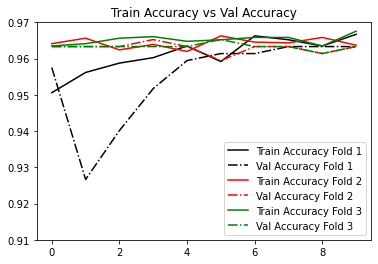

In [128]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")

plt.yticks([0.910, 0.920, 0.930,0.940,0.950,0.960, 0.970]) 
plt.legend()
plt.show()

In [5]:

y_pred = model.predict(merged_test)
conf = sklearn.metrics.confusion_matrix(ytest, np.rint(y_pred))

Text(91.68, 0.5, 'Actual label')

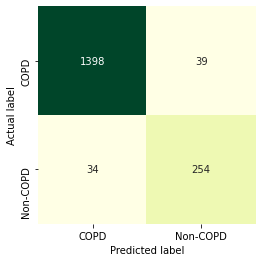

In [126]:
class_labels = ['COPD','Non-COPD']

sns.heatmap(conf, square=True, annot=True, fmt='d', cbar=False, cmap='YlGn',
             xticklabels=class_labels,
             yticklabels=class_labels)

# plt.figure(figsize=(5,3))
# sns.heatmap(conf, annot=True,cmap="YlGn",fmt='g')
# plt.show()

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [127]:
#Accuracy from confusion matrix
TP= conf[1,1] #True positive
TN= conf[0,0] #True negative
FP= conf[0,1] #False positive
FN= conf[1,0] #False negative

precision = TN/(TN+FN)
recall = TN/(TN+FP)
f1_score = 2*precision*recall/(precision + recall)
Total=len(ytest)

print("Accuracy from confusion matrix is ", (TN+TP)/Total)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1_score: ",f1_score)

Accuracy from confusion matrix is  0.9576811594202899
Precision:  0.9762569832402235
Recall:  0.9728601252609603
F1_score:  0.9745555942837225
